# Stage 2b: Generate AI Alpha Factors

- Compute target values (y)
    - Quantize with 2 bins for testing
    - Quantize with 25 bins for production
- Train model for Feature importance
- Feature reduction
- Train model for AI Alpha Vector
- Compute AI Alpha Vectors for 1 year
- Save AI Alpha Vectors

In [17]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

# Set the import path for the tools directiory
import sys
# insert at position 1 in the path, as 0 is the path of this file.
sys.path.insert(1, '../tools')
import importlib
import ameritrade_functions as amc
importlib.reload(amc)
import utils
importlib.reload(utils)
import trading_factors as alpha_factors
importlib.reload(alpha_factors)

print(f'Python version : {python_version()}')
print(f'Pandas version : {pd.__version__}')

Python version : 3.8.10
Pandas version : 0.25.3


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [2]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

masked_account_number = '#---5311'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories.csv'

# Price History data from Stage 1

In [3]:
price_histories = utils.read_price_histories(price_histories_file_name)
print(f'Date range for price histories: {price_histories.date.min().date()} to {price_histories.date.max().date()}')
pricing = utils.get_close_values(price_histories)
print(f'You have {len(pricing.columns)} stocks')
print(pricing.columns.to_list())
pricing.tail()

Date range for price histories: 2018-07-02 to 2021-07-02
You have 32 stocks
['AAPL', 'AEI', 'AIH', 'BABA', 'CAN', 'COKE', 'CONN', 'DKNG', 'EFOI', 'GMGMF', 'GOOG', 'IBM', 'JZXN', 'LEDS', 'LX', 'MGM', 'MOSY', 'MSFT', 'NMRD', 'NNXPF', 'OCG', 'OEG', 'PDYPF', 'PRTK', 'QFIN', 'RCON', 'TELL', 'TLRY', 'TSLA', 'VTNR', 'WKHS', 'ZKIN']


ticker,AAPL,AEI,AIH,BABA,CAN,COKE,CONN,DKNG,EFOI,GMGMF,...,PDYPF,PRTK,QFIN,RCON,TELL,TLRY,TSLA,VTNR,WKHS,ZKIN
date,,,,,,,,,,,,,,,,,,,,,
2021-06-28 00:00:00+00:00,134.78,6.11,7.96,228.59,7.95,402.00,26.43,52.71,4.03,1.85000,...,189.000,6.90,41.72,4.19,4.41,18.630,688.72,9.94,16.96,4.31
2021-06-29 00:00:00+00:00,136.33,6.02,8.28,229.44,8.15,398.39,25.43,52.03,4.08,1.72000,...,185.500,6.81,42.55,4.10,4.23,17.860,680.76,10.27,17.20,4.20
2021-06-30 00:00:00+00:00,136.96,5.68,7.96,226.78,8.15,402.13,25.50,52.17,3.98,1.69536,...,181.615,6.82,41.84,4.33,4.65,18.080,679.70,13.23,16.59,4.29
2021-07-01 00:00:00+00:00,137.27,5.31,8.10,221.87,7.62,397.16,25.90,51.80,3.90,1.70000,...,187.375,7.24,38.79,4.20,4.66,17.835,677.92,12.04,15.64,4.23
2021-07-02 00:00:00+00:00,139.96,5.63,8.22,217.75,7.32,393.39,25.77,51.28,4.42,1.72000,...,186.000,6.94,35.74,4.09,4.43,17.230,678.90,11.04,14.17,3.95


## Read existing factors

In [4]:
all_factors = pd.read_csv('data/all_factors.csv', parse_dates=['date'])
all_factors.set_index(['date', 'ticker'], inplace=True)
all_factors.sort_index(inplace=True)
all_assets = all_factors.index.levels[1].values.tolist()
print(f'Factors from date: {all_factors.index.levels[0].min()} to date: {all_factors.index.levels[0].max()}')
print(f'Stocks: {all_assets}')
all_factors.sort_values(['ticker', 'date']).tail(10)

Factors from date: 2019-07-03 00:00:00+00:00 to date: 2021-07-02 00:00:00+00:00
Stocks: ['AAPL', 'AEI', 'AIH', 'BABA', 'CAN', 'COKE', 'CONN', 'DKNG', 'EFOI', 'GMGMF', 'GOOG', 'IBM', 'JZXN', 'LEDS', 'LX', 'MGM', 'MOSY', 'MSFT', 'NMRD', 'NNXPF', 'OCG', 'OEG', 'PDYPF', 'PRTK', 'QFIN', 'RCON', 'TELL', 'TLRY', 'TSLA', 'VTNR', 'WKHS', 'ZKIN']


,,momentum_252_day_logret,mean_reversion_5_day_logret_smoothed,overnight_sentiment_5_day_smoothed,annualzed_volatility_20_day,annualzed_volatility_120_day,average_dollar_volume_20_day,average_dollar_volume_120_day,market_dispersion20_day,market_dispersion120_day,market_volatility20_day,market_volatility120_day,is_January,is_December,weekday,quarter,year,month_start,month_end,quarter_start,quarter_end
date,ticker,,,,,,,,,,,,,,,,,,,,
2021-06-21 00:00:00+00:00,ZKIN,0.812296,0.812296,1.137214,0.487377,0.812296,-1.353826,-0.162459,0.080193,0.066450,0.363158,0.356857,0,0,0,2,2021,0,0,0,0
2021-06-22 00:00:00+00:00,ZKIN,0.812296,0.703989,1.137214,0.487377,0.812296,-1.353826,-0.162459,0.078282,0.066329,0.341091,0.355654,0,0,1,2,2021,0,0,0,0
2021-06-23 00:00:00+00:00,ZKIN,0.812296,0.595683,1.137214,0.162459,0.812296,-1.353826,-0.162459,0.077511,0.066380,0.363235,0.357147,0,0,2,2,2021,0,0,0,0
2021-06-24 00:00:00+00:00,ZKIN,0.812296,1.137214,1.353826,0.270765,0.812296,-1.353826,-0.162459,0.076761,0.066221,0.350076,0.358823,0,0,3,2,2021,0,0,0,0
2021-06-25 00:00:00+00:00,ZKIN,0.703989,1.137214,1.462132,-0.054153,0.812296,-1.353826,-0.162459,0.071021,0.066130,0.315902,0.358972,0,0,4,2,2021,0,0,0,0
2021-06-28 00:00:00+00:00,ZKIN,0.595683,1.137214,1.570438,-0.162459,0.812296,-1.353826,-0.162459,0.065142,0.066004,0.308469,0.355851,0,0,0,2,2021,0,0,0,0
2021-06-29 00:00:00+00:00,ZKIN,0.595683,1.245520,1.570438,-0.162459,0.812296,-1.245520,-0.162459,0.059040,0.065889,0.248229,0.357112,0,0,1,2,2021,0,0,0,0
2021-06-30 00:00:00+00:00,ZKIN,0.595683,1.137214,1.570438,-0.595683,0.812296,-1.245520,-0.162459,0.057310,0.065856,0.233206,0.352731,0,0,2,2,2021,0,1,0,1
2021-07-01 00:00:00+00:00,ZKIN,0.812296,0.920602,1.462132,-0.703989,0.920602,-1.245520,-0.162459,0.054226,0.065714,0.211132,0.353084,0,0,3,3,2021,1,0,1,0


## Compute the target values (y) and Shift back to create a 5 day forward prediciton

This is something you want to experiment with. If you are planning on holding on to assets for long periods of time, perhaps a 20, 40 or 60 forward prediciton will work better.

In [5]:
target_source = '5Day2Quant'
forward_prediciton_days = 5

all_factors = pd.concat(
[
    all_factors,
    alpha_factors.FactorReturnQuantiles(price_histories, 2, 5).for_al(target_source),
], axis=1).dropna()
all_factors.sort_index(inplace=True)
display(all_factors.head())

all_factors['target'] = all_factors.groupby(level='ticker')[target_source].shift(-forward_prediciton_days)
all_factors[[target_source,'target']].reset_index().sort_values(['ticker', 'date']).head(10)

momentum_252_day_logret  \
date                      ticker                            
2019-07-03 00:00:00+00:00 AAPL                   1.146070   
                          AEI                    0.436598   
                          AIH                    0.436598   
                          BABA                  -0.272874   
                          CAN                    0.436598   

                                  mean_reversion_5_day_logret_smoothed  \
date                      ticker                                         
2019-07-03 00:00:00+00:00 AAPL                               -1.255220   
                          AEI                                 0.764047   
                          AIH                                 0.764047   
                          BABA                               -1.691818   
                          CAN                                 0.764047   

                                  overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2019-07-03 00:00:00+00:00 AAPL                              0.487377   
                          AEI                              -1.353826   
                          AIH                              -1.462132   
                          BABA                              1.570438   
                          CAN                              -1.570438   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2019-07-03 00:00:00+00:00 AAPL                      -0.054575   
                          AEI                       -1.309795   
                          AIH                       -1.309795   
                          BABA                       1.036921   
                          CAN                       -1.309795   

                                  annualzed_volatility_120_day  \
date                      ticker                                 
2019-07-03 00:00:00+00:00 AAPL                        0.600323   
                          AEI                        -1.309795   
                          AIH                        -1.309795   
                          BABA                        0.163724   
                          CAN                        -1.309795   

                                  average_dollar_volume_20_day  \
date                      ticker                                 
2019-07-03 00:00:00+00:00 AAPL                        1.691818   
                          AEI                        -1.309795   
                          AIH                        -1.309795   
                          BABA                        1.582669   
                          CAN                        -1.309795   

                                  average_dollar_volume_120_day  \
date                      ticker                                  
2019-07-03 00:00:00+00:00 AAPL                         1.691818   
                          AEI                         -1.309795   
                          AIH                         -1.309795   
                          BABA                         1.473519   
                          CAN                         -1.309795   

                                  market_dispersion20_day  \
date                      ticker                            
2019-07-03 00:00:00+00:00 AAPL                   0.027712   
                          AEI                    0.027712   
                          AIH                    0.027712   
                          BABA                   0.027712   
                          CAN                    0.027712   

                                  market_dispersion120_day  \
date                      ticker                             
2019-07-03 00:00:00+00:00 AAPL                    0.033048   
                          AEI                     0.033048   
                          AIH                     0.03

,date,ticker,5Day2Quant,target
0,2019-07-03 00:00:00+00:00,AAPL,1,0.0
32,2019-07-05 00:00:00+00:00,AAPL,1,0.0
64,2019-07-08 00:00:00+00:00,AAPL,1,1.0
96,2019-07-09 00:00:00+00:00,AAPL,0,1.0
128,2019-07-10 00:00:00+00:00,AAPL,1,1.0
160,2019-07-11 00:00:00+00:00,AAPL,0,1.0
192,2019-07-12 00:00:00+00:00,AAPL,0,1.0
224,2019-07-15 00:00:00+00:00,AAPL,1,1.0
256,2019-07-16 00:00:00+00:00,AAPL,1,1.0
288,2019-07-17 00:00:00+00:00,AAPL,1,1.0


### IID Check of Target
Let's see if the returns are independent and identically distributed.

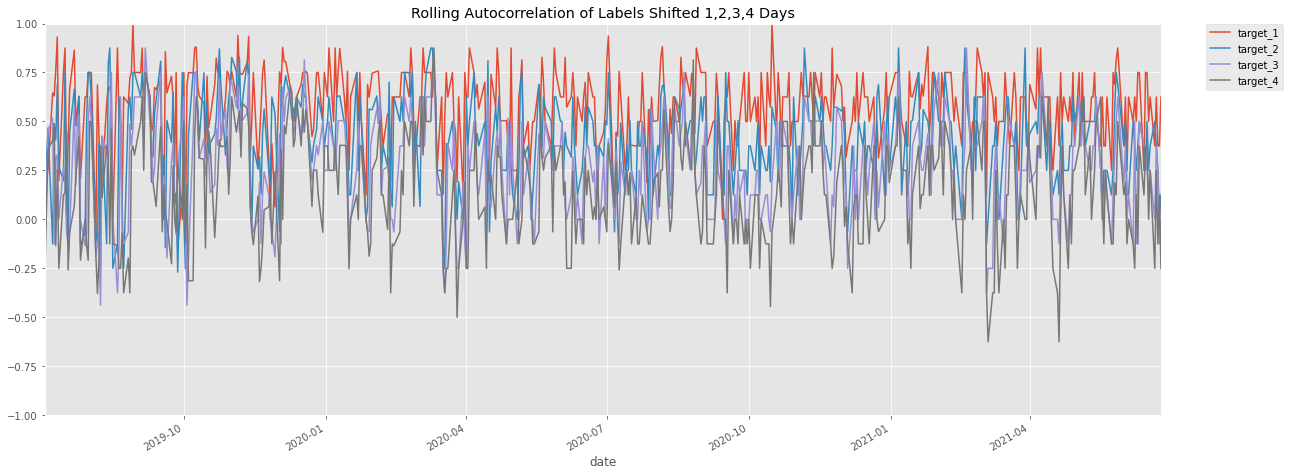

In [6]:
from scipy.stats import spearmanr

def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]


all_factors['target_1'] = all_factors.groupby(level='ticker')[target_source].shift(-4)
all_factors['target_2'] = all_factors.groupby(level='ticker')[target_source].shift(-3)
all_factors['target_3'] = all_factors.groupby(level='ticker')[target_source].shift(-2)
all_factors['target_4'] = all_factors.groupby(level='ticker')[target_source].shift(-1)

g = all_factors.dropna().groupby(level='date')
for i in range(4):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, 'target', label)
    ic.plot(ylim=(-1, 1), label=label)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()

## Evaluate Autocorrelation IID Results

As you can see, the further out from the target (target_4) we are the less correlated the data is.

In [7]:
all_factors.columns.values

array(['momentum_252_day_logret', 'mean_reversion_5_day_logret_smoothed',
       'overnight_sentiment_5_day_smoothed',
       'annualzed_volatility_20_day', 'annualzed_volatility_120_day',
       'average_dollar_volume_20_day', 'average_dollar_volume_120_day',
       'market_dispersion20_day', 'market_dispersion120_day',
       'market_volatility20_day', 'market_volatility120_day',
       'is_January', 'is_December', 'weekday', 'quarter', 'year',
       'month_start', 'month_end', 'quarter_start', 'quarter_end',
       '5Day2Quant', 'target', 'target_1', 'target_2', 'target_3',
       'target_4'], dtype=object)

In [8]:
features = ['momentum_252_day_logret', 'mean_reversion_5_day_logret_smoothed',
       'overnight_sentiment_5_day_smoothed',
       'annualzed_volatility_20_day', 'annualzed_volatility_120_day',
       'average_dollar_volume_20_day', 'average_dollar_volume_120_day',
       'market_dispersion20_day', 'market_dispersion120_day',
       'market_volatility20_day', 'market_volatility120_day',
       'is_January', 'is_December', 'weekday', 'quarter', 'year',
       'month_start', 'month_end', 'quarter_start', 'quarter_end']

target_label = 'target'

temp = all_factors.dropna().copy()
X = temp[features]
y = temp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = utils.train_valid_test_split(X, y, 0.7, 0.15, 0.15)

X_train.head()

1.0


momentum_252_day_logret  \
date                      ticker                            
2019-07-03 00:00:00+00:00 AAPL                   1.146070   
                          AEI                    0.436598   
                          AIH                    0.436598   
                          BABA                  -0.272874   
                          CAN                    0.436598   

                                  mean_reversion_5_day_logret_smoothed  \
date                      ticker                                         
2019-07-03 00:00:00+00:00 AAPL                               -1.255220   
                          AEI                                 0.764047   
                          AIH                                 0.764047   
                          BABA                               -1.691818   
                          CAN                                 0.764047   

                                  overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2019-07-03 00:00:00+00:00 AAPL                              0.487377   
                          AEI                              -1.353826   
                          AIH                              -1.462132   
                          BABA                              1.570438   
                          CAN                              -1.570438   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2019-07-03 00:00:00+00:00 AAPL                      -0.054575   
                          AEI                       -1.309795   
                          AIH                       -1.309795   
                          BABA                       1.036921   
                          CAN                       -1.309795   

                                  annualzed_volatility_120_day  \
date                      ticker                                 
2019-07-03 00:00:00+00:00 AAPL                        0.600323   
                          AEI                        -1.309795   
                          AIH                        -1.309795   
                          BABA                        0.163724   
                          CAN                        -1.309795   

                                  average_dollar_volume_20_day  \
date                      ticker                                 
2019-07-03 00:00:00+00:00 AAPL                        1.691818   
                          AEI                        -1.309795   
                          AIH                        -1.309795   
                          BABA                        1.582669   
                          CAN                        -1.309795   

                                  average_dollar_volume_120_day  \
date                      ticker                                  
2019-07-03 00:00:00+00:00 AAPL                         1.691818   
                          AEI                         -1.309795   
                          AIH                         -1.309795   
                          BABA                         1.473519   
                          CAN                         -1.309795   

                                  market_dispersion20_day  \
date                      ticker                            
2019-07-03 00:00:00+00:00 AAPL                   0.027712   
                          AEI                    0.027712   
                          AIH                    0.027712   
                          BABA                   0.027712   
                          CAN                    0.027712   

                                  market_dispersion120_day  \
date                      ticker                             
2019-07-03 00:00:00+00:00 AAPL                    0.033048   
                          AEI                     0.033048   
                          AIH                     0.03

## Build and Train a model to derive our AI generated Alpha
### Build an ensemble of non-overlapping trees
Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

#### Non Overlapping Estimators
With `calculate_oob_score` implemented, let's create non overlapping estimators. Implement `non_overlapping_estimators` to build non overlapping subsets of the data, then run a estimator on each subset of data.

In [9]:
import abc

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

print(f'Sci-Kit version: {sklearn.__version__}')


class NoOverlapVoterAbstract(VotingClassifier):
    @abc.abstractmethod
    def _calculate_oob_score(self, classifiers):
        raise NotImplementedError
        
    @abc.abstractmethod
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        raise NotImplementedError
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        self.estimator = estimator
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        self.feature_importances_ = self.feature_importances(self.estimators_)
        
        return self
    
class NoOverlapVoter(NoOverlapVoterAbstract):
            
    def _calculate_oob_score(self, classifiers):
        oob_scores = []
        for classifier in classifiers:
            oob_scores.append(classifier.oob_score_)

        return np.mean(oob_scores)
    
    def feature_importances(self, classifiers):
        feature_importances = []
        for classifier in classifiers:
            feature_importances.append(classifier.feature_importances_)
            
        return np.mean(feature_importances, axis=0)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        fit_classifiers = []
        for clf_idx in range(len(classifiers)):
            x_samp, y_samp = utils.non_overlapping_samples(x, y, n_skip_samples, clf_idx)
            fit_classifiers.append(classifiers[clf_idx].fit(x_samp, y_samp))

        return fit_classifiers

Sci-Kit version: 0.24.1


#### Train Model

In [10]:
n_days = 8
n_stocks = len(set(all_factors.index.get_level_values(level='ticker').values))
clf_random_state = 42

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_days * n_stocks,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [50, 100, 250, 1000]

Training Models:   0%|          | 0/4 [00:00<?, ?Model/s]

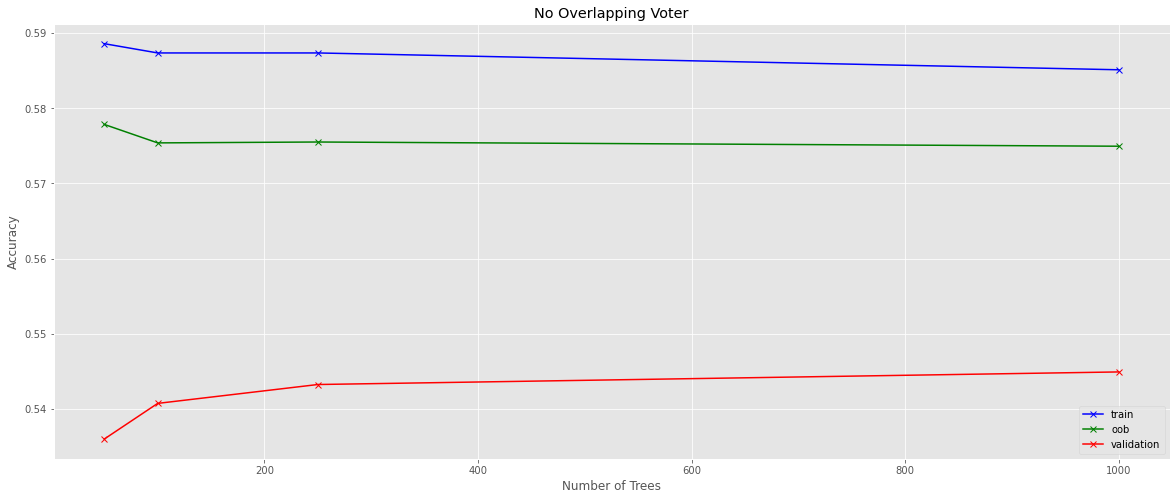

In [11]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)
    
utils.plot_results(n_trees_l, train_score, oob_score, valid_score, ['train', 'oob', 'validation'], 'No Overlapping Voter', 'Number of Trees')

In [12]:
factor_names = [
     'mean_reversion_5_day_logret_smoothed',
     'momentum_252_day_logret',
     'overnight_sentiment_5_day_smoothed',
     'average_dollar_volume_120_day',
     'annualzed_volatility_20_day'
]

Cleaning Data...

Dropped 5.7% entries from factor data: 0.0% in forward returns computation and 5.7% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.9% entries from factor data: 0.0% in forward returns computation and 2.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                      Sharpe Ratio
mean_reversion_5_day_logret_smoothed         -0.13
momentum_252_day_logret                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

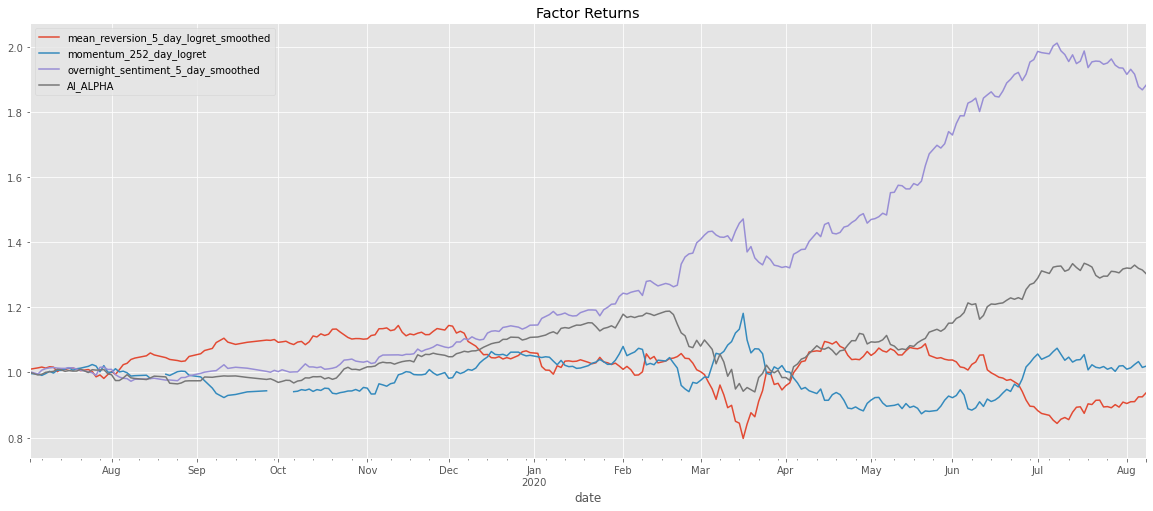

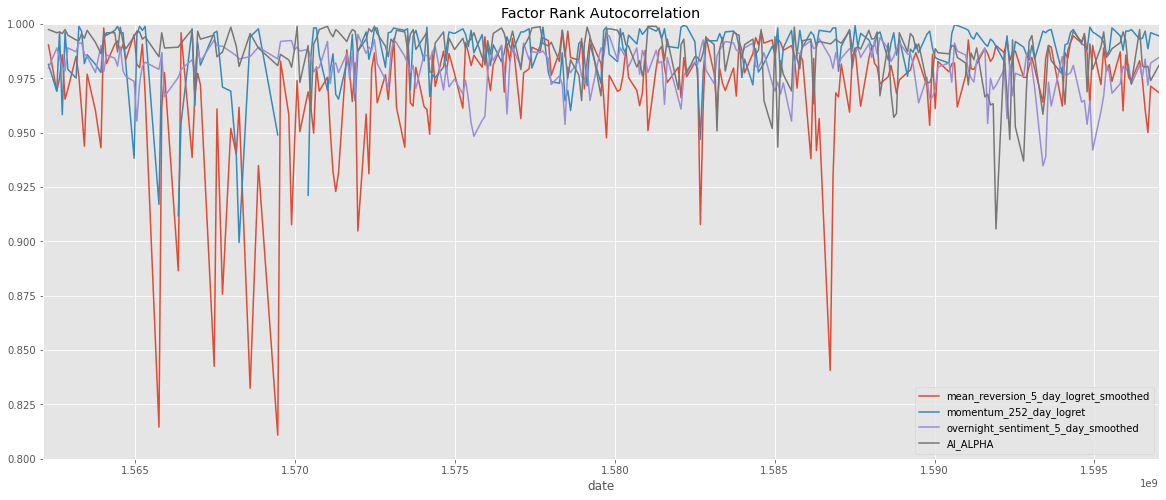

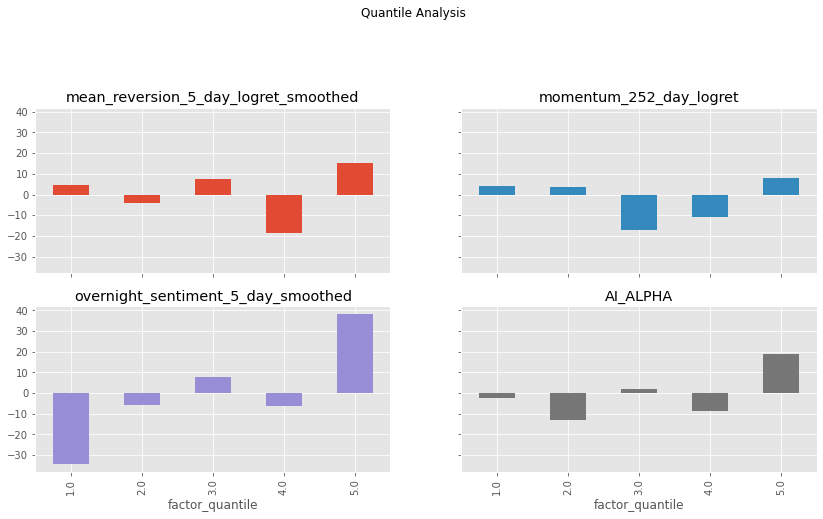

In [18]:
alpha_factors.evaluate_ai_alpha(all_factors, X_train, clf_nov, factor_names, pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                      Sharpe Ratio
mean_reversion_5_day_logret_smoothed         -1.38
momentum_252_day_logret                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

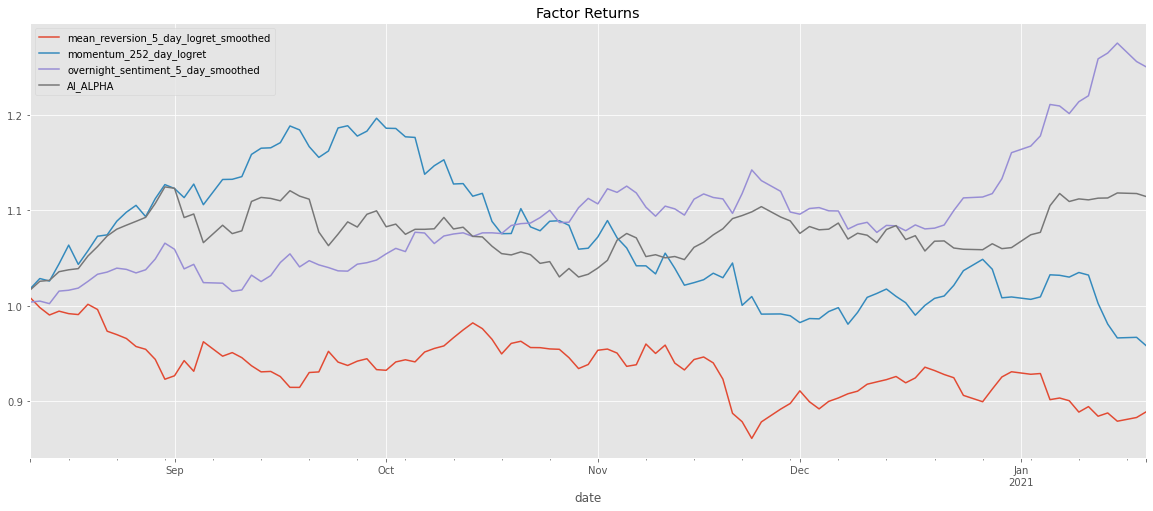

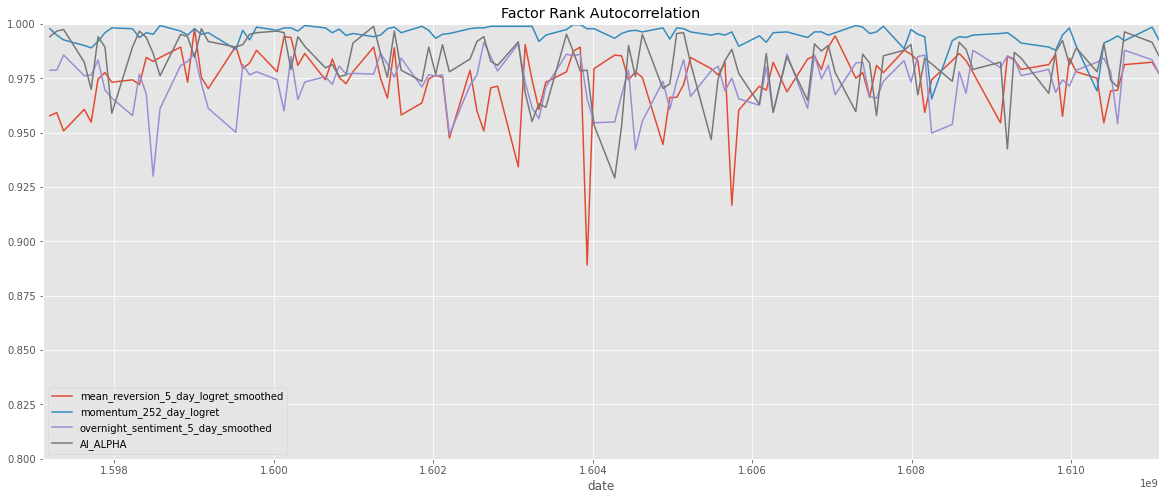

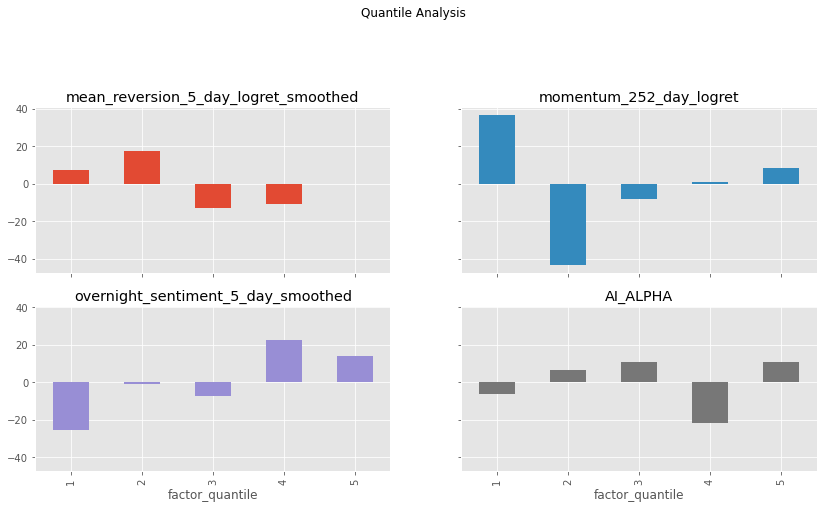

In [19]:
alpha_factors.evaluate_ai_alpha(all_factors, X_valid, clf_nov, factor_names, pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [20]:
print('Features Ranked by Average Importance:\n')
ranked_features = utils.rank_features_by_importance(clf_nov.feature_importances_, features)
ranked_features

Features Ranked by Average Importance:

      Feature                                  Importance
 1. average_dollar_volume_20_day         (0.1977832374624125)
 2. average_dollar_volume_120_day        (0.18772916304630544)
 3. annualzed_volatility_20_day          (0.11977714762025302)
 4. overnight_sentiment_5_day_smoothed   (0.11621033628736029)
 5. annualzed_volatility_120_day         (0.1140618115789634)
 6. momentum_252_day_logret              (0.08999744810703289)
 7. mean_reversion_5_day_logret_smoothed (0.03905576686464963)
 8. market_volatility20_day              (0.029796202328455694)
 9. market_dispersion20_day              (0.029380230268101937)
10. market_dispersion120_day             (0.027977088132321276)
11. market_volatility120_day             (0.020597130850281857)
12. quarter                              (0.01154719170349391)
13. year                                 (0.010265511615562616)
14. weekday                              (0.005821734134805559)
15. is_January  

['average_dollar_volume_20_day',
 'average_dollar_volume_120_day',
 'annualzed_volatility_20_day',
 'overnight_sentiment_5_day_smoothed',
 'annualzed_volatility_120_day',
 'momentum_252_day_logret',
 'mean_reversion_5_day_logret_smoothed',
 'market_volatility20_day',
 'market_dispersion20_day',
 'market_dispersion120_day',
 'market_volatility120_day',
 'quarter',
 'year',
 'weekday',
 'is_January',
 'quarter_start',
 'is_December',
 'month_start',
 'month_end',
 'quarter_end']

In [21]:
features_to_use = ranked_features[0:6]
print(features_to_use)

['average_dollar_volume_20_day', 'average_dollar_volume_120_day', 'annualzed_volatility_20_day', 'overnight_sentiment_5_day_smoothed', 'annualzed_volatility_120_day', 'momentum_252_day_logret']


In [22]:
prod_target_source = '5Day20Quant'
forward_prediciton_days = 5

all_factors = pd.concat(
[
    all_factors,
    alpha_factors.FactorReturnQuantiles(price_histories, 20, 5).for_al(prod_target_source),
], axis=1).dropna()
all_factors.sort_index(inplace=True)
display(all_factors.head())

all_factors['target'] = all_factors.groupby(level='ticker')[prod_target_source].shift(-forward_prediciton_days)
all_factors[[prod_target_source,'target']].reset_index().sort_values(['ticker', 'date']).head(10)

momentum_252_day_logret  \
date                      ticker                            
2019-07-03 00:00:00+00:00 AAPL                   1.146070   
                          AEI                    0.436598   
                          AIH                    0.436598   
                          BABA                  -0.272874   
                          CAN                    0.436598   

                                  mean_reversion_5_day_logret_smoothed  \
date                      ticker                                         
2019-07-03 00:00:00+00:00 AAPL                               -1.255220   
                          AEI                                 0.764047   
                          AIH                                 0.764047   
                          BABA                               -1.691818   
                          CAN                                 0.764047   

                                  overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2019-07-03 00:00:00+00:00 AAPL                              0.487377   
                          AEI                              -1.353826   
                          AIH                              -1.462132   
                          BABA                              1.570438   
                          CAN                              -1.570438   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2019-07-03 00:00:00+00:00 AAPL                      -0.054575   
                          AEI                       -1.309795   
                          AIH                       -1.309795   
                          BABA                       1.036921   
                          CAN                       -1.309795   

                                  annualzed_volatility_120_day  \
date                      ticker                                 
2019-07-03 00:00:00+00:00 AAPL                        0.600323   
                          AEI                        -1.309795   
                          AIH                        -1.309795   
                          BABA                        0.163724   
                          CAN                        -1.309795   

                                  average_dollar_volume_20_day  \
date                      ticker                                 
2019-07-03 00:00:00+00:00 AAPL                        1.691818   
                          AEI                        -1.309795   
                          AIH                        -1.309795   
                          BABA                        1.582669   
                          CAN                        -1.309795   

                                  average_dollar_volume_120_day  \
date                      ticker                                  
2019-07-03 00:00:00+00:00 AAPL                         1.691818   
                          AEI                         -1.309795   
                          AIH                         -1.309795   
                          BABA                         1.473519   
                          CAN                         -1.309795   

                                  market_dispersion20_day  \
date                      ticker                            
2019-07-03 00:00:00+00:00 AAPL                   0.027712   
                          AEI                    0.027712   
                          AIH                    0.027712   
                          BABA                   0.027712   
                          CAN                    0.027712   

                                  market_dispersion120_day  \
date                      ticker                             
2019-07-03 00:00:00+00:00 AAPL                    0.033048   
                          AEI                     0.033048   
                          AIH                     0.03

,date,ticker,5Day20Quant,target
0,2019-07-03 00:00:00+00:00,AAPL,6,6.0
32,2019-07-05 00:00:00+00:00,AAPL,9,6.0
64,2019-07-08 00:00:00+00:00,AAPL,9,10.0
96,2019-07-09 00:00:00+00:00,AAPL,7,10.0
128,2019-07-10 00:00:00+00:00,AAPL,9,10.0
160,2019-07-11 00:00:00+00:00,AAPL,6,11.0
192,2019-07-12 00:00:00+00:00,AAPL,6,10.0
224,2019-07-15 00:00:00+00:00,AAPL,10,13.0
256,2019-07-16 00:00:00+00:00,AAPL,10,13.0
288,2019-07-17 00:00:00+00:00,AAPL,10,9.0


In [23]:
temp = all_factors.dropna().copy()
X = temp[features_to_use]
y = temp['target']

X_train, X_valid, X_test, y_train, y_valid, y_test = utils.train_valid_test_split(X, y, 0.7, 0.15, 0.15)

1.0


In [24]:
clf = RandomForestClassifier(2000, **clf_parameters)

clf_nov = NoOverlapVoter(clf)
clf_nov.fit(X, y)

NoOverlapVoter(estimator=RandomForestClassifier(criterion='entropy',
                                                min_samples_leaf=256,
                                                n_estimators=2000, n_jobs=-1,
                                                oob_score=True,
                                                random_state=42))

### Results
#### Accuracy

In [25]:
print('train: {}, oob: {}, valid: {}, test:{}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.score(X_test, y_test.values),
    clf_nov.oob_score_))

train: 0.11704749103942652, oob: 0.10825892857142858, valid: 0.08473557692307693, test:0.10006313131313131


#### Train

Cleaning Data...

Dropped 28.7% entries from factor data: 0.0% in forward returns computation and 28.7% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 28.7% entries from factor data: 0.0% in forward returns computation and 28.7% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 28.7% entries from factor data: 0.0% in forward returns computation and 28.7% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 28.7% entries from factor data: 0.0% in forward returns computation and 28.7% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exc

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

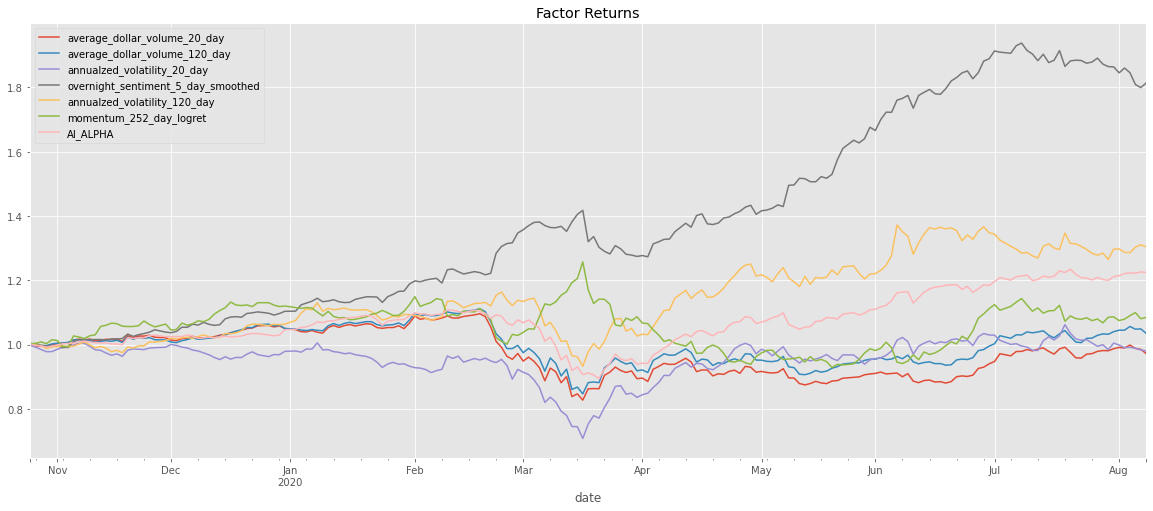

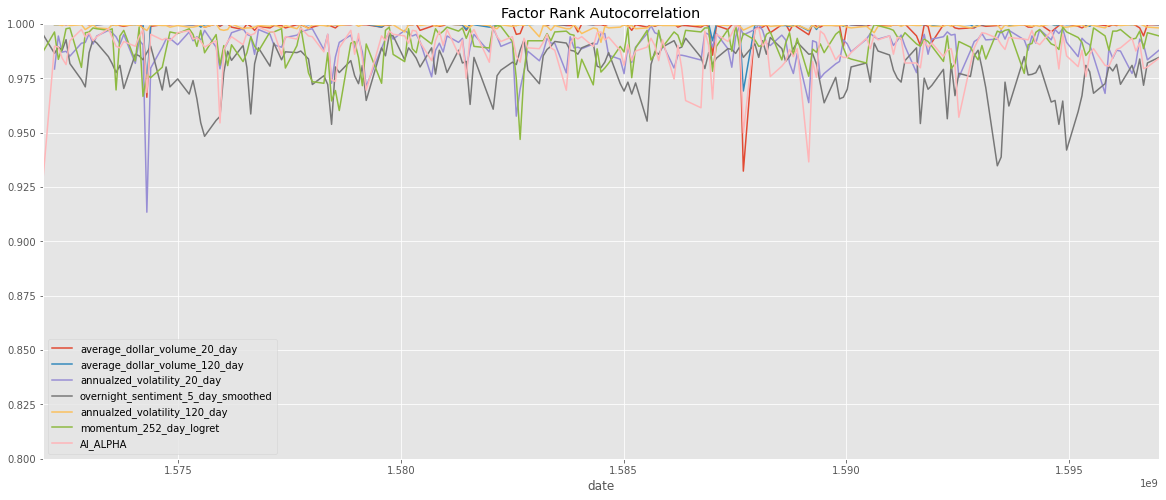

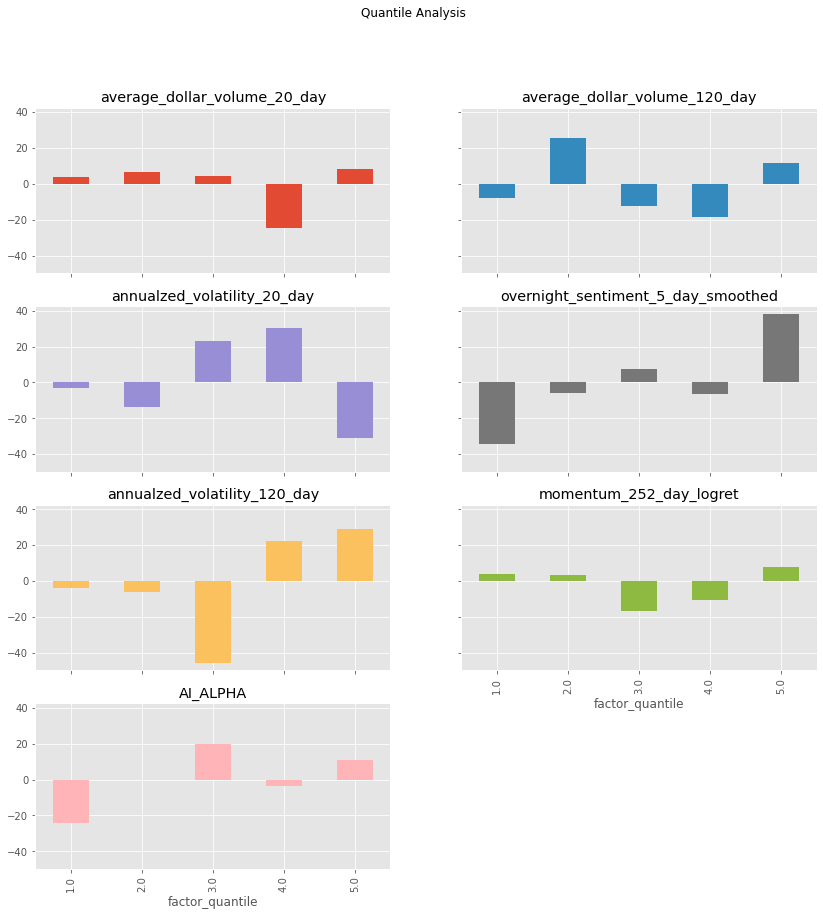

In [26]:
alpha_factors.evaluate_ai_alpha(all_factors, X_train, clf_nov, features_to_use, pricing)

Cleaning Data...

Dropped 28.7% entries from factor data: 0.0% in forward returns computation and 28.7% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 28.7% entries from factor data: 0.0% in forward returns computation and 28.7% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 28.7% entries from factor data: 0.0% in forward returns computation and 28.7% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 28.7% entries from factor data: 0.0% in forward returns computation and 28.7% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exc

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

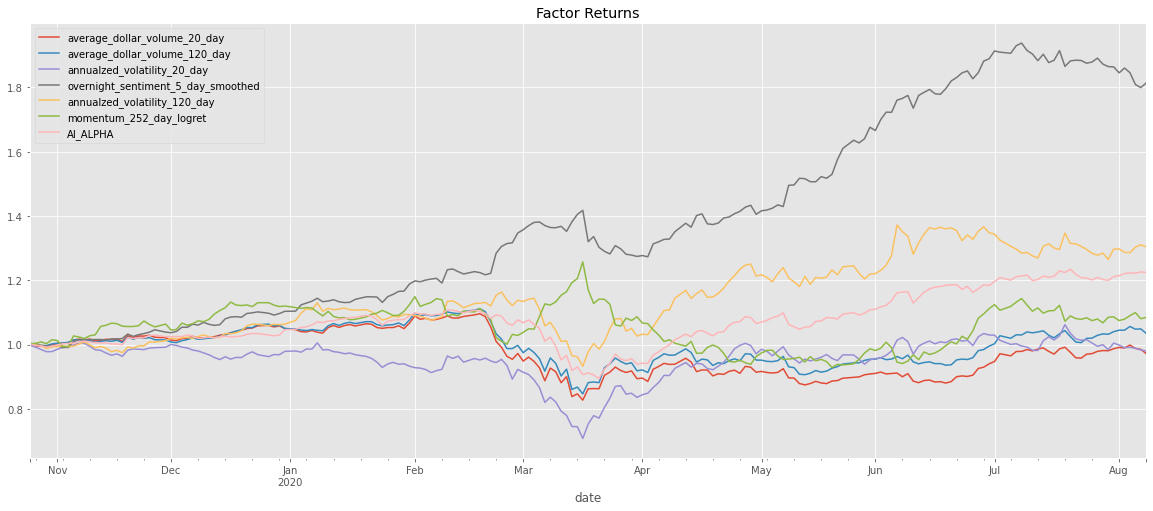

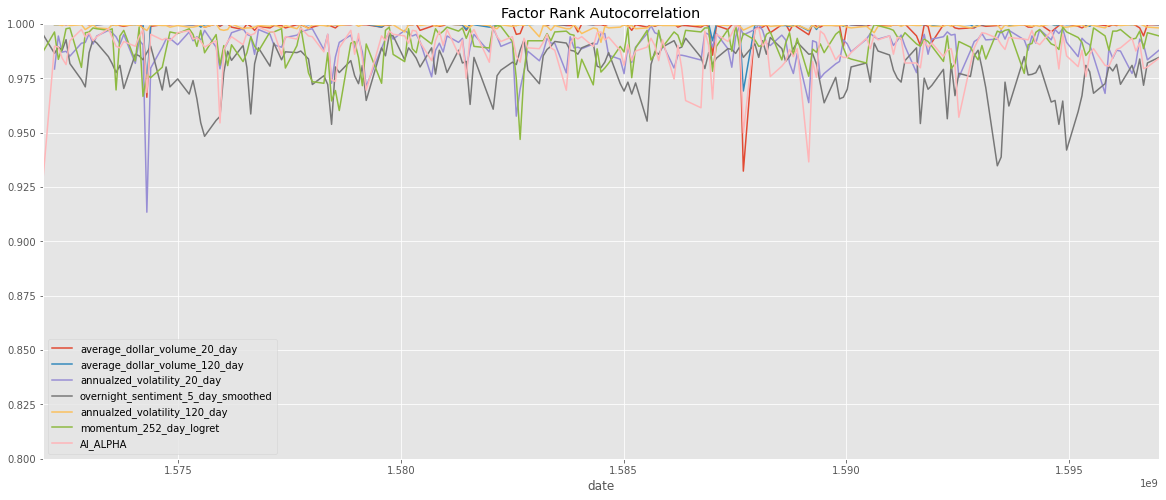

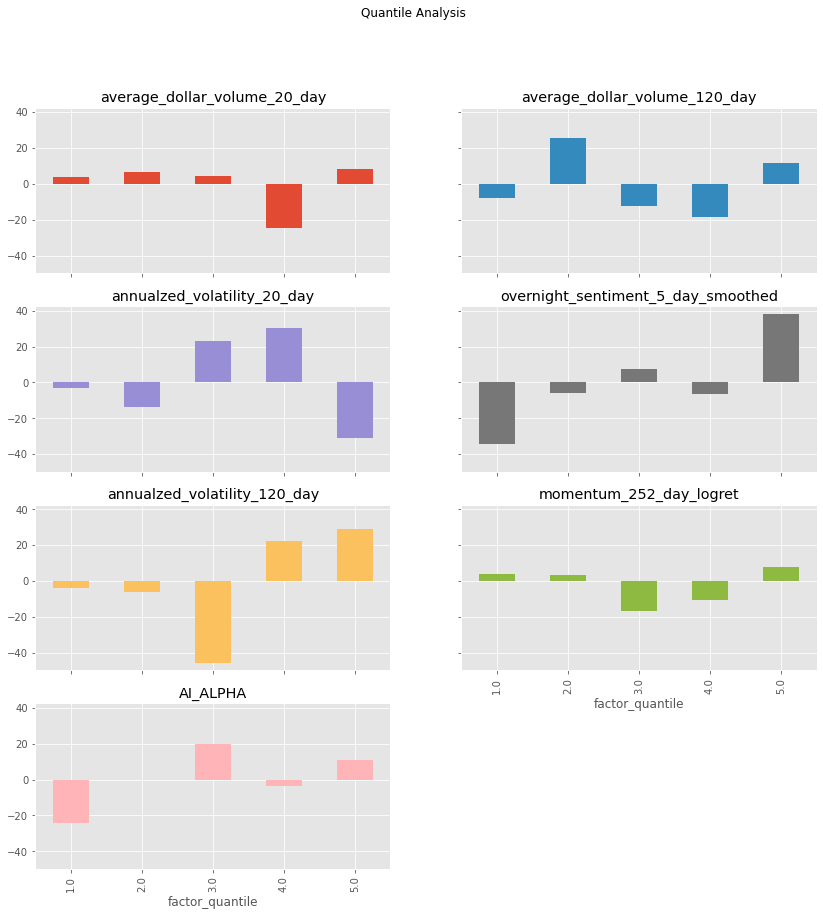

In [27]:
alpha_factors.evaluate_ai_alpha(all_factors, X_train, clf_nov, features_to_use, pricing)

#### Validation

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

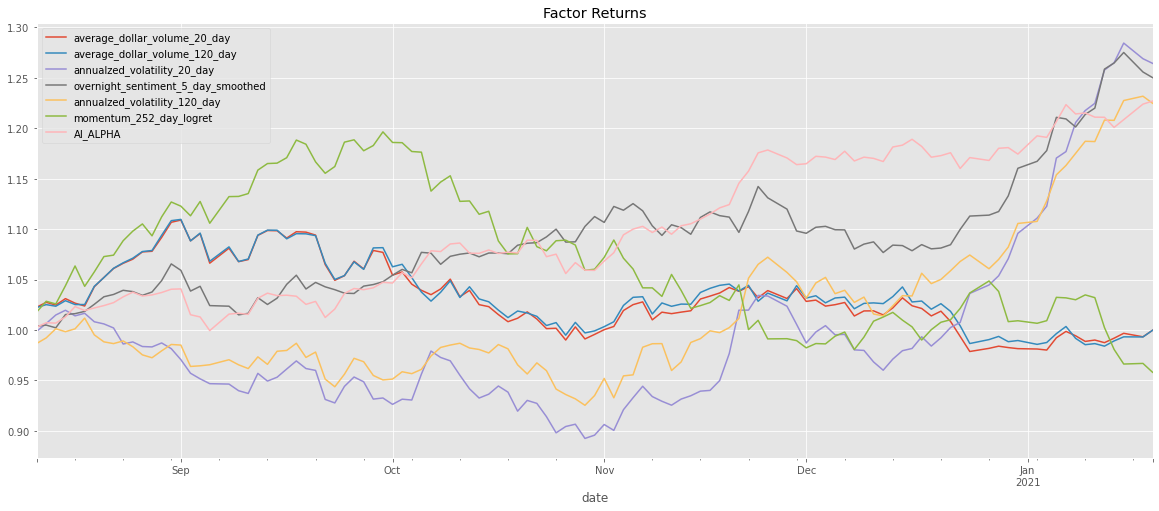

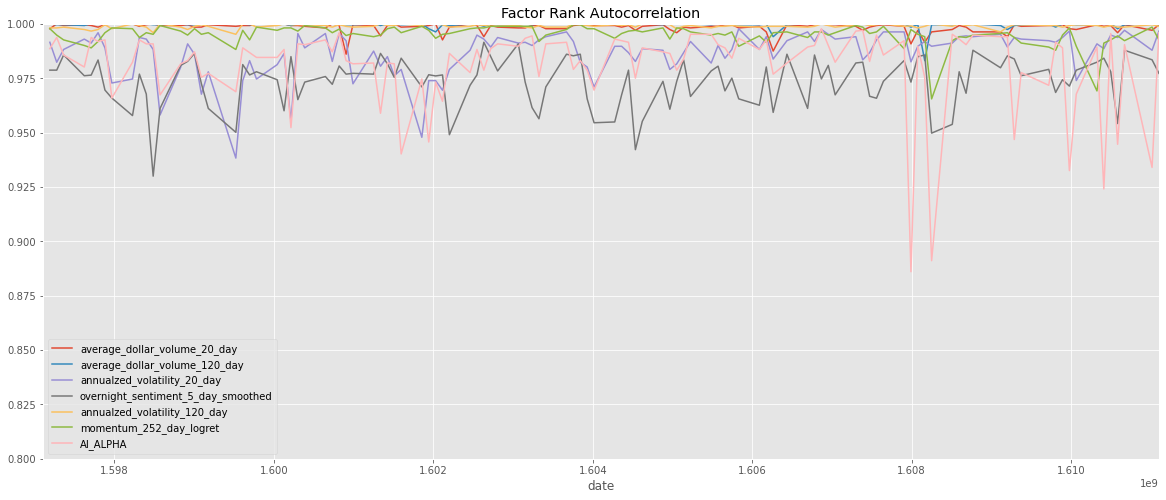

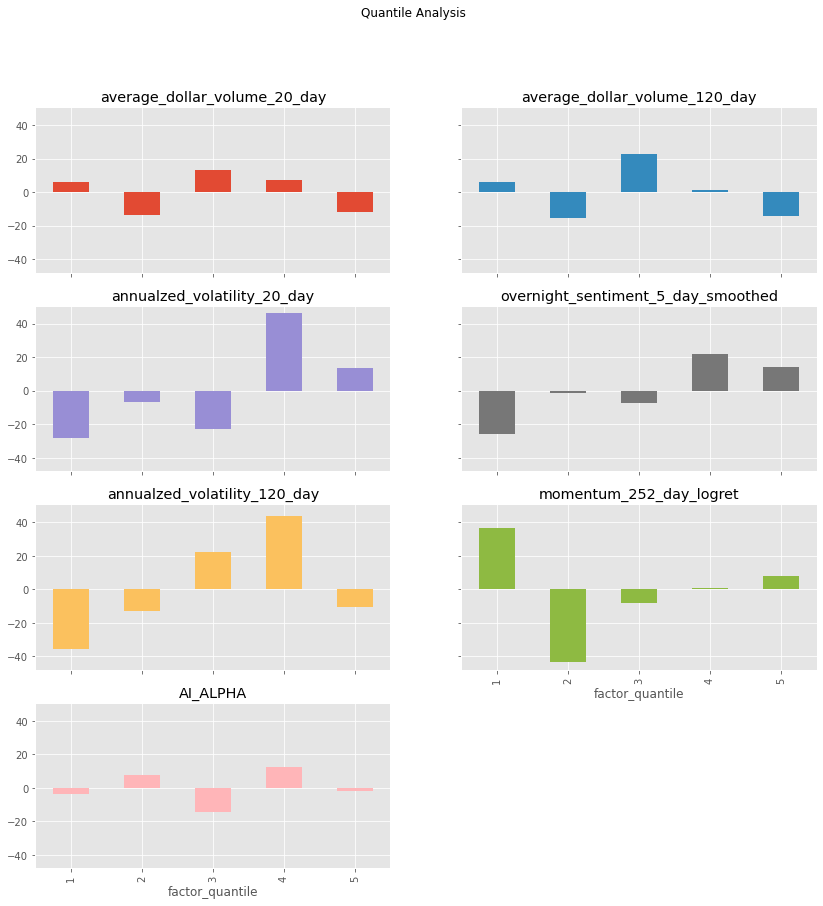

In [28]:
alpha_factors.evaluate_ai_alpha(all_factors, X_valid, clf_nov, features_to_use, pricing)

#### Test

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

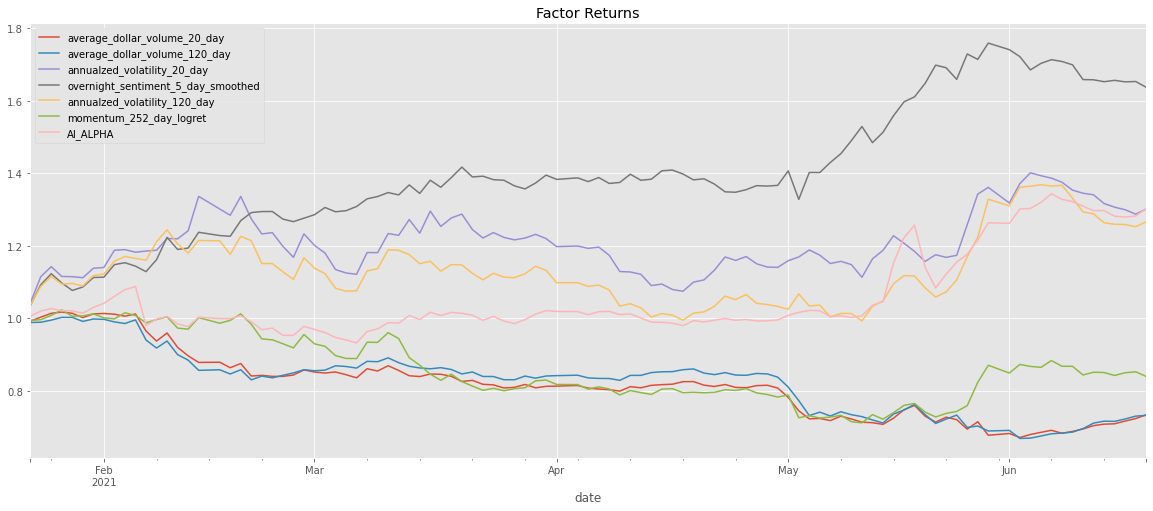

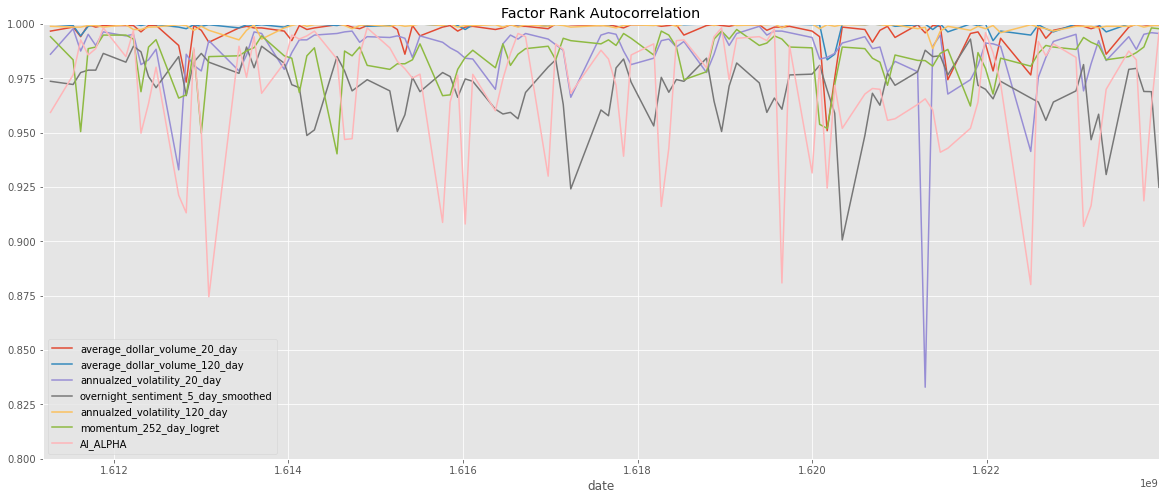

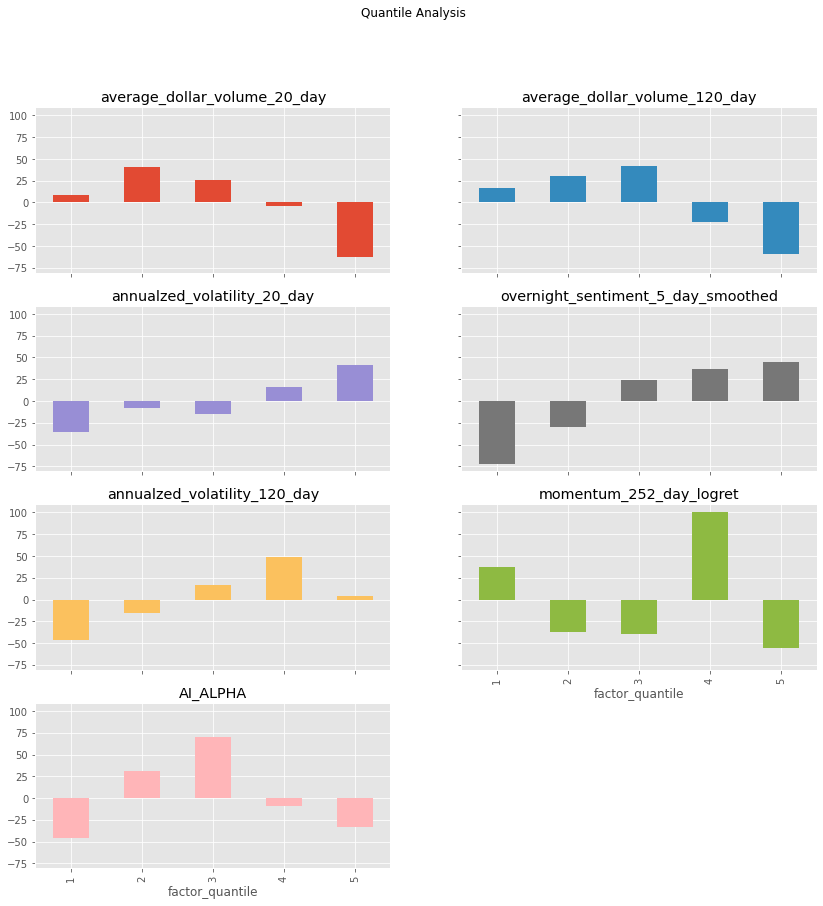

In [29]:
alpha_factors.evaluate_ai_alpha(all_factors, X_test, clf_nov, features_to_use, pricing)

Cleaning Data...

Dropped 16.2% entries from factor data: 0.0% in forward returns computation and 16.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 16.2% entries from factor data: 0.0% in forward returns computation and 16.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 16.2% entries from factor data: 0.0% in forward returns computation and 16.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 16.2% entries from factor data: 0.0% in forward returns computation and 16.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exc

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

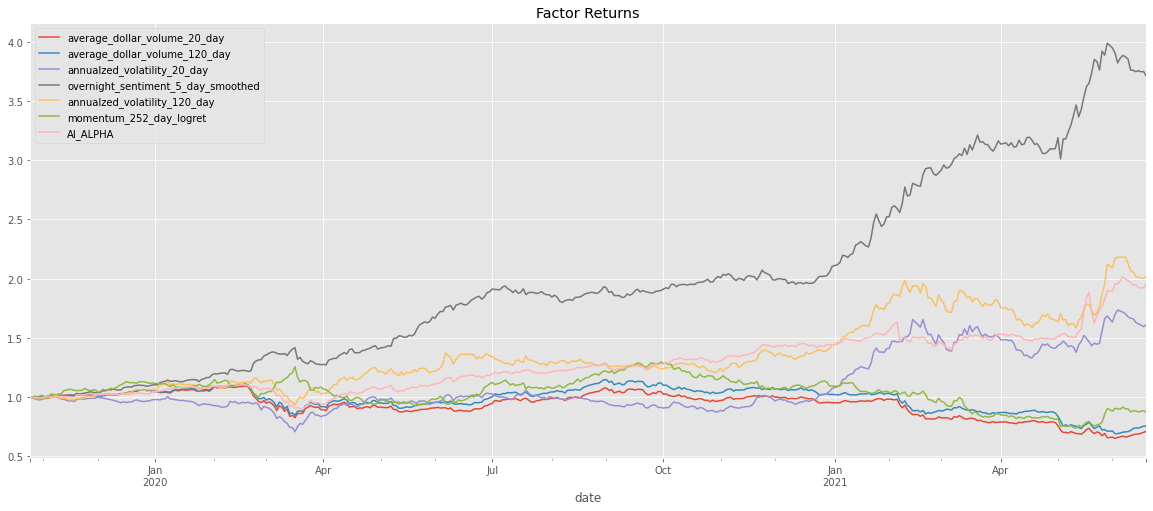

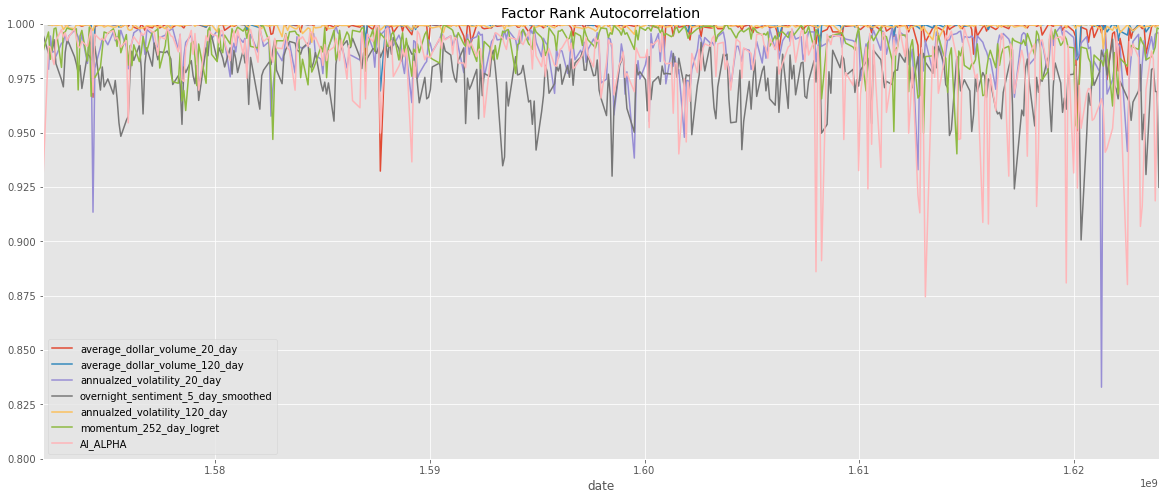

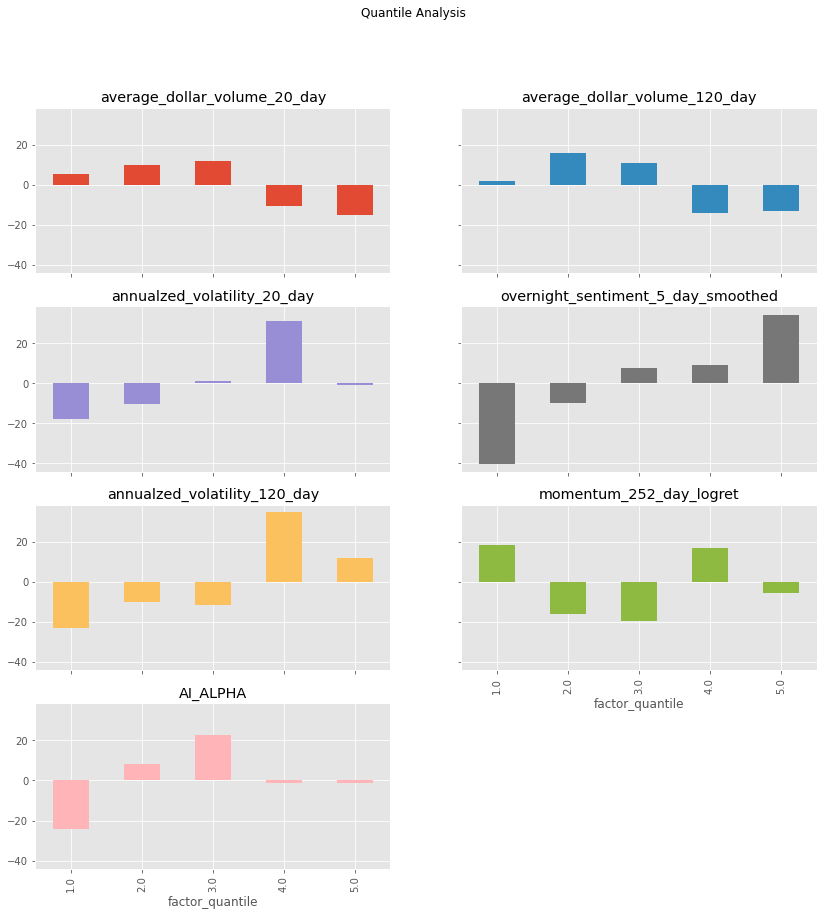

In [30]:
alpha_factors.evaluate_ai_alpha(all_factors, X, clf_nov, features_to_use, pricing)

## TODO:

- Generate AI Factor from all data (turn into function) Currently using 1/2 as low and 1/2 as high performers based on quantils
- Store AI Factor Information
- Store Model (This might not be necessary. If the model is to be retrained on the same parameters, then we might just need them. this is for the production AI)
- Store Model parameters
- Store features to use

# Stopped here

# TODO

- Use AI Alpha from top factors
- Get daily Alpha/Beta/Idiosyncratic...
- Compute optimization parameters
- Init holdings
- Run Backtests
- Generate Portfolio

### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

In [ ]:
optimal_weights = OptimalHoldings(risk_cap=0.05,weights_max=0.12, weights_min=-0.12).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
print(f'Old portfolio variance is:  {risk_model.compute_portfolio_variance(sotck_universe_weights):.8f}')
print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')
display((optimal_weights*100).round(2))
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')

#x_axis = plt.axes().get_xaxis()
#x_axis.set_visible(False)

In [ ]:
investment_amount = portfun.get_account_value(stock_universe_values).round(2)
print(f'Current investment amount: {investment_amount}')
optimal_weights['amount'] = (optimal_weights['optimalWeights'] * investment_amount).round(0)
optimal_weights['marketValue'] = stock_universe_values['marketValue']
optimal_weights['buy/sell'] = (optimal_weights['marketValue'] - optimal_weights['amount']) * -1
optimal_weights['close'] = pricing.iloc[-1]
optimal_weights['existingShares'] = stock_universe_values['longQuantity']
optimal_weights['deltaShares'] = (optimal_weights['buy/sell'] / optimal_weights['close']).round(0)
optimal_weights['deltaMarketValue'] = (optimal_weights['deltaShares'] * optimal_weights['close'])
optimal_weights['totalShares'] = (optimal_weights['existingShares'] + optimal_weights['deltaShares'])
optimal_weights['totalMarketValue'] = (optimal_weights['totalShares'] * optimal_weights['close'])
optimal_weights

## Think or Swim Simulator

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] <= 0) & (optimal_weights['deltaShares'] == 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)][['deltaMarketValue', 'totalMarketValue']].sum().round(2)